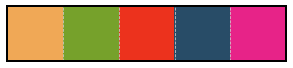

In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
import seaborn as sns
import copy
import math
%matplotlib inline

sns.set_style("whitegrid", {'axes.grid' : True})
sns.set_context("paper", font_scale=1.5)

plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 'axes.grid': True, 'grid.linestyle': '--'})

colors = ['#F0A856', '#76A12B', '#EC321D', '#284C67', '#E72388']
sns.palplot(colors)
sns.set_palette(sns.color_palette(colors), 8, .75)
line_style = dict(linewidth = 2, markersize = 8, err_style = "bars",)

sub_figure_title = {"fontweight": 700, 'fontname':'Times New Roman', 'fontsize': 18}
markers = {"MemoryMode": "s", "TupleCache": "v", "AlchemyTuple": "^", "AlchemySync": "<", "Alchemy": ">", "PMem": "p", "DRAM": "P"}

In [2]:
def load_data(bench_dir):
    files = os.listdir(bench_dir)
    bench_data = []
    for f in files:
        data = json.load(open(f'{bench_dir}/{f}'))

        for b in data["run"]:
            n_data = data.copy()
            if b["pcm"]:
                b["pcm"] = b["pcm"][0]
            n_data["run"] = b

            for i in n_data["run"]["results"]:
                inner_d = n_data.copy()
                inner_d["run"]["results"] = i
                bench_data.append(inner_d)
    bench_data = pd.json_normalize(bench_data)
    return bench_data

hue_order = ["MemoryMode", "TupleCache", "AlchemyTuple", "AlchemySync", "Alchemy"]
markers = {"MemoryMode": "s", "TupleCache": "v", "AlchemyTuple": "^", "AlchemySync": "<", "Alchemy": ">", "PM only": "p", "DRAM only": "P"}


In [3]:
pd_tpcc = load_data("tpcc-01-28")

def label_basic(row):
	if row["config.name"] == "tpcc-tpcc_mm":
		return "MemoryMode"
	elif row["config.policy"] == "Field" and row["config.txn_engine"] == "Async":
		return "Alchemy"
	elif row["config.policy"] == "Field" and row["config.txn_engine"] == "Sync":
		return "AlchemySync"
	elif row["config.policy"] == "Tuple" and row["config.txn_engine"] == "Async":
		return "AlchemyTuple"
	elif row["config.policy"] == "Tuple" and row["config.txn_engine"] == "Sync":
		return "TupleCache"
	else:
		print("Error: {}", row["config.name"])
		return ""

def pm_total_bw(row):
	return row["run.pcm.pm_read"] + row["run.pcm.pm_write"]



pd_tpcc["config.label"] = pd_tpcc.apply(lambda x: label_basic(x), axis=1)
pd_tpcc["run.pcm.pm_total"] = pd_tpcc.apply(lambda x: pm_total_bw(x), axis=1)


In [4]:
pd_logging = load_data("logging-02-11")

def label_logging(row):
	if row["config.name"] == "tpcc-logging-null":
		return "Null device"
	elif row["config.name"] == "tpcc-logging-pm-file":
		return "PM - file"
	elif row["config.name"] == "tpcc-logging-pm-byte":
		return "PM - byte"
	elif row["config.name"] == "tpcc-logging-ssd":
		return "SSD"
	else:	
		print("Error: {}", row["config.name"])
		return ""

pd_logging["config.label"] = pd_logging.apply(lambda x: label_logging(x), axis=1)
pd_logging = pd_logging.sort_values(by=['run.results.new_order.commit'])

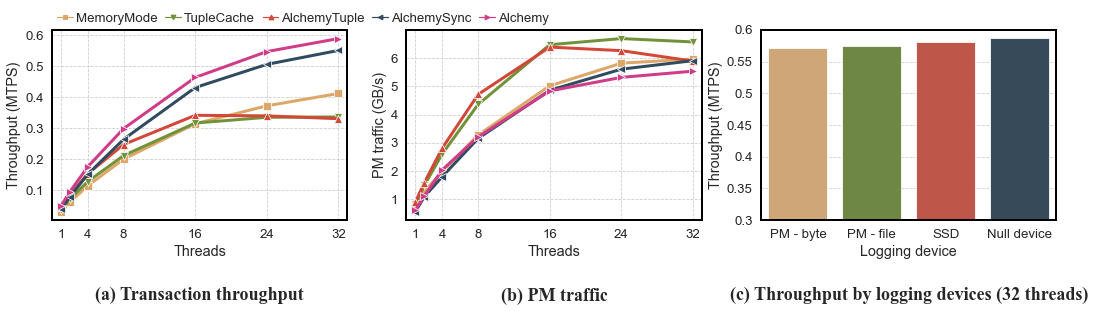

In [7]:
line_style_b = dict(linewidth = 3, markersize = 8, err_style = "bars")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 3.5))
ax1 = sns.lineplot(ax=ax1, x="run.thread_cnt", y="run.results.new_order.commit", hue="config.label",
                  style = "config.label", dashes=[(), (), (), (), ()],
                hue_order=hue_order,
                  **line_style_b, data=pd_tpcc, markers=markers)
ax1.set(xlabel='Threads', ylabel='Throughput (MTPS)', xlim=(0,33))
ax1.legend(loc=(0,1), ncol=5, columnspacing=0.6, handlelength=1.2, handletextpad=0.2, frameon=False).set_title("")
ax1.set_title("(a) Transaction throughput", y=-0.45, fontdict=sub_figure_title)

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000000}'))
ax1.xaxis.set_major_locator(ticker.FixedLocator([1,4,8,16,24,32]))


ax2 = sns.lineplot(ax=ax2, x="run.thread_cnt", y="run.pcm.pm_total", hue="config.label",
                   style="config.label", markers=markers, dashes=[(), (), (), (), ()],
                   hue_order=hue_order,
                   **line_style_b, data=pd_tpcc)
ax2.legend().remove()
ax2.set(xlabel='Threads', ylabel='PM traffic (GB/s)', xlim=(0,33))
ax2.set_title("(b) PM traffic", y=-0.45, fontdict= sub_figure_title)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000000000)}'))
ax2.xaxis.set_major_locator(ticker.FixedLocator([1,4,8,16,24,32]))
# ax2.yaxis.set_major_locator(ticker.FixedLocator([0, 1000000000,2000000000,3000000000,4000000000]))

sns.barplot(ax=ax3, data = pd_logging, x="config.label", y="run.results.new_order.commit")

ax3.set(xlabel='Logging device', ylabel='Throughput (MTPS)', ylim=(300_000, 600_000))
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000_000}'))
ax3.set_title("(c) Throughput by logging devices (32 threads)", y=-0.45, fontdict= sub_figure_title)

fig.savefig("./tpcc-thrpt.pdf", bbox_inches='tight', pad_inches=0.1)



### Compare other transactions on 32 threads

In [5]:
pd_other = pd_tpcc.loc[(pd_tpcc["run.thread_cnt"] == 32)]

txn_mapping = {"new_order": "run.results.new_order.commit", 
			   "payment": "run.results.payment.commit", 
			   "order_status": "run.results.order_status.commit", 
			   "delivery": "run.results.delivery.commit", 
			   "stock_level": "run.results.stock_level.commit"}

pd_all_txn = pd.DataFrame()
for idx, row in pd_other.iterrows():
	for k, v in txn_mapping.items():
		tmp = row.copy()
		tmp["display.commit"] = tmp[v]
		tmp["display.txn"] = k
		pd_all_txn = pd_all_txn.append(tmp)

pd_all_txn.reset_index(inplace=True)


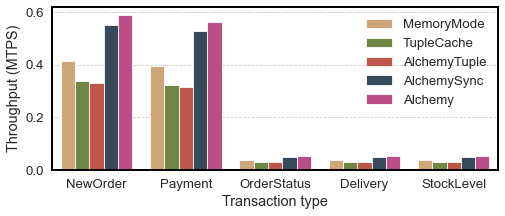

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
sns.barplot(data = pd_all_txn, x="display.txn", y="display.commit", hue="config.label",
			hue_order=hue_order)

ax.legend(frameon=False).set_title("")
ax.set(xlabel='Transaction type', ylabel='Throughput (MTPS)')
ax.set_xticklabels(['NewOrder','Payment','OrderStatus','Delivery','StockLevel'])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000_000}'))

# Latency

In [7]:
pd_latency = load_data("tpcc-latency-02-02")


hue_order = ["TupleCache", "AlchemyTuple", "AlchemySync", "Alchemy"]
markers = {"TupleCache": "v", "AlchemyTuple": "^", "AlchemySync": "<", "Alchemy": ">", "PM only": "p", "DRAM only": "P"}


pd_latency["config.label"] = pd_latency.apply(lambda x: label_basic(x), axis=1)
pd_latency = pd_latency.explode("run.results.metrics.timers.tpcc").reset_index(drop=True)

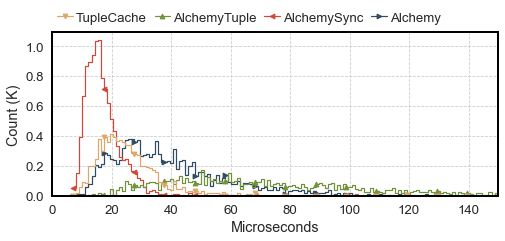

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(8,3))
sns.histplot(data=pd_latency, ax=axes, x="run.results.metrics.timers.tpcc",
            hue="config.label", bins=6000, fill=False,element="step", 
            hue_order=hue_order)
axes.set(xlim=(0, 150_000))
axes.set(xlabel='Microseconds', ylabel='Count (K)', title='')
# axes.set_yscale("log")
axes.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}'))

old_legend = axes.legend_
handles = old_legend.legendHandles
all_texts = old_legend.get_texts()
labels = [t.get_text() for t in all_texts]
for i, line in enumerate(handles):
    line.set_marker(markers[all_texts[i].get_text()])
axes.legend(handles, labels, loc=(0, 1.02), title="", ncol=5, columnspacing=0.6, handlelength=1.2, handletextpad=0.2, frameon=False).set_title("")

# This is hardcode order, I don't know how to figure out the order of lines...
marker_order = [">", "<", "^", "v"]
for i, line in enumerate(axes.get_lines()):
    line.set_marker(marker_order[i])
    line.set_markevery(10)


axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000}'))
fig.savefig("./tpcc-lat.pdf", bbox_inches='tight', pad_inches=0.1)


In [9]:
def get_quantile(data, label):
    data = data[data["config.label"] == label]
    data = data["run.results.metrics.timers.tpcc"]
    print(f"{label}:\n {data.quantile([.5, .9, .95, 0.99, 0.999])}")

get_quantile(pd_latency, "TupleCache")
get_quantile(pd_latency, "AlchemyTuple")
get_quantile(pd_latency, "AlchemySync")
get_quantile(pd_latency, "Alchemy")

TupleCache:
 0.500      23787.0
0.900      40505.0
0.950      50433.0
0.990    902196.04
0.999    1113184.0
Name: run.results.metrics.timers.tpcc, dtype: object
AlchemyTuple:
 0.500      67836.0
0.900     134662.0
0.950     179373.8
0.990    1188580.0
0.999    5611247.0
Name: run.results.metrics.timers.tpcc, dtype: object
AlchemySync:
 0.500      15948.0
0.900      25846.0
0.950      29546.0
0.990     728701.0
0.999    1073220.0
Name: run.results.metrics.timers.tpcc, dtype: object
Alchemy:
 0.500      35437.0
0.900      70524.0
0.950      88136.0
0.990     903883.2
0.999    1128931.0
Name: run.results.metrics.timers.tpcc, dtype: object
